In [27]:
import os
import sys
import glob
import math
import itertools
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# Add parent directory to path
sys.path.append(str(Path("..").resolve()))
from data_handling import load_state_npz

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_dir = Path("models")

print(f"Running on: {device}")
print(f"Looking for models in: {models_dir.resolve()}")

# Load Reference Data (The Exact Diagonalization curve we made earlier)
ref_file = Path(f"tfim_4x4_fidelity_ref.csv")
if ref_file.exists():
    ref_df = pd.read_csv(ref_file)
    print("Loaded reference CSV.")
else:
    ref_df = None
    print("Warning: Reference CSV not found.")

Running on: cpu
Looking for models in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_over_4x4_tests/models
Loaded reference CSV.


In [32]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T
        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_flip).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        fe_v = term1_v - term2_v
        fe_flipped = term1_f - term2_f

        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, n_samples: int, rng: torch.Generator, burn_in: int = 50):
        cond = cond.to(device)
        if cond.dim() == 1: cond = cond.expand(n_samples, -1)
        b_mod, c_mod = self._compute_effective_biases(cond)

        probs = torch.full((n_samples, self.num_visible), 0.5, device=device)
        v = torch.bernoulli(probs, generator=rng)

        for _ in range(burn_in):
            v = self._gibbs_step(v, b_mod, c_mod, rng)
        return v

In [33]:
def load_latest_model():
    pt_files = sorted(glob.glob(str(models_dir / "*.pt")), key=os.path.getmtime, reverse=True)
    if not pt_files:
        raise FileNotFoundError("No .pt files found.")

    latest_path = Path(pt_files[0])
    print(f"Loading checkpoint: {latest_path.name}")

    checkpoint = torch.load(latest_path, map_location=device)
    config = checkpoint["config"]

    model = ConditionalRBM(
        num_visible=config["num_visible"],
        num_hidden=config["num_hidden"],
        cond_dim=1,
        k=config.get("k_steps", 1),
    ).to(device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model, config

model, config = load_latest_model()
h_support = config.get("h_support", [])
GEN_SIDE_LENGTH = int(math.sqrt(model.num_visible))

print(f"Model Loaded. System Size: {GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}")
print(f"Support Points: {h_support}")

Loading checkpoint: crbm_tfim_4x4_50000_20251210_223015.pt
Model Loaded. System Size: 4x4
Support Points: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]


In [37]:
def estimate_susceptibility_mc(model, h_val, n_samples=20000):
    """
    Estimates Chi_F using the Variance of Log-Derivatives.
    chi_F = Var( d(log_psi)/dh )

    This is a pure Monte Carlo estimator.
    """
    # 0. Get model dtype (likely float32)
    dtype = next(model.parameters()).dtype

    # 1. Generate Samples (No Gradients)
    rng = torch.Generator(device=device).manual_seed(42)

    with torch.no_grad():
        # FIX: Ensure h_val matches model dtype
        cond_fixed = torch.tensor([[h_val]], device=device, dtype=dtype)
        samples = model.generate(cond_fixed, n_samples, rng, burn_in=100)

    # 2. Forward Pass with Gradients
    # We create a new condition tensor that requires grad
    # shape: (Batch, 1) because each sample needs its own gradient source for autograd to work per-sample
    cond_batch = torch.full((n_samples, 1), h_val, device=device, dtype=dtype, requires_grad=True)

    # Compute Log Psi
    log_psi = model.log_score(samples, cond_batch)

    # 3. Compute Gradients (Backprop)
    # We use torch.autograd.grad to get d(log_psi) / d(h)
    # grad_outputs=ones preserves the individual gradients because the Jacobian is diagonal
    # (i.e., sample i's probability only depends on condition row i)
    grads = torch.autograd.grad(
        outputs=log_psi,
        inputs=cond_batch,
        grad_outputs=torch.ones_like(log_psi),
        create_graph=False
    )[0]

    # grads shape: [n_samples, 1] -> flatten to [n_samples]
    local_gradients = grads.squeeze()

    # 4. Compute Variance
    # chi = < O^2 > - < O >^2
    chi = torch.var(local_gradients, unbiased=True)

    return chi.item()

In [38]:
# Create a dense sweep to see the peak
h_eval = np.linspace(1.0, 4.0, 40)

print(f"Estimating Susceptibility (MC) on {len(h_eval)} points...")

chi_values = []

for h in h_eval:
    # h is numpy float64, function handles cast to float32
    chi = estimate_susceptibility_mc(model, h, n_samples=50000)
    chi_values.append(chi)

    # Print progress near critical point
    if 2.9 < h < 3.1:
        print(f"h={h:.2f} | chi={chi:.4f}")

print("Sweep Complete.")

Estimating Susceptibility (MC) on 40 points...
h=2.92 | chi=0.5099
h=3.00 | chi=0.4167
h=3.08 | chi=0.3327
Sweep Complete.


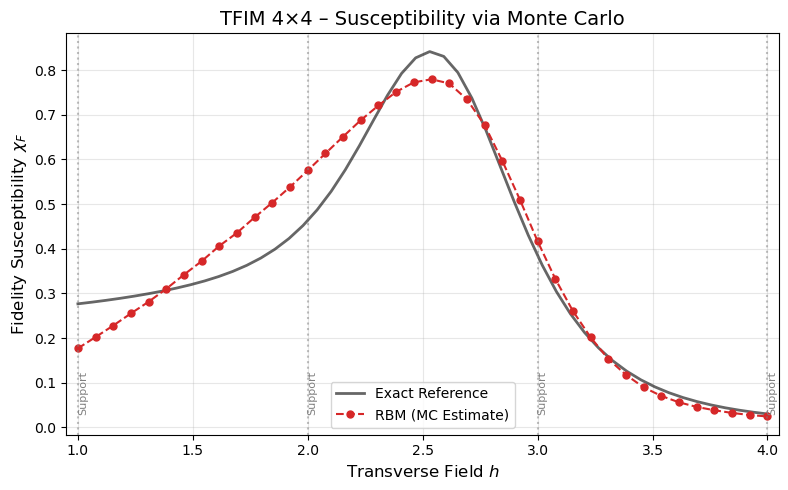

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), dpi=100)

# 1. Reference Curve (Exact)
if ref_df is not None:
    plt.plot(
        ref_df["h"].values,
        ref_df["chi_F"].values,
        "-",
        color="black",
        alpha=0.6,
        linewidth=2,
        label="Exact Reference",
    )

# 2. RBM Monte Carlo Estimate
plt.plot(
    h_eval,
    chi_values,
    "o--",
    color="tab:red",
    markersize=5,
    label="RBM (MC Estimate)",
)

# 3. Mark support (training) points
ymin, ymax = plt.ylim()
for h_supp in h_support:
    if 1.0 <= h_supp <= 4.0:
        plt.axvline(
            h_supp,
            color="gray",
            linestyle=":",
            alpha=0.5
        )
        plt.text(
            h_supp,
            ymin + 0.05 * (ymax - ymin),
            "Support",
            rotation=90,
            va="bottom",
            color="gray",
            fontsize=8
        )

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility $\chi_F$", fontsize=12)
plt.title("TFIM 4×4 – Susceptibility via Monte Carlo", fontsize=14)

plt.xlim(0.95, 4.05)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
